# Human Activity Recognition from Video Streams

## Project Overview

This notebook implements a complete training pipeline for Human Activity Recognition (HAR) using EfficientNet-B3 architecture. The model is trained to classify 15 different human activities from RGB images extracted from video frames.

## Dataset Information

- Training Dataset: 12,600 labeled images across 15 activity classes
- Classes: calling, clapping, cycling, dancing, drinking, eating, fighting, hugging, laughing, listening_to_music, running, sitting, sleeping, texting, using_laptop
- Image Resolution: Variable (resized to 160x160 during preprocessing)
- Train-Validation Split: 80% training, 20% validation (automatic split using ImageDataGenerator)


## Section 1: Import Required Libraries

This section imports all necessary libraries for data loading, preprocessing, model building, training, and evaluation.


In [1]:
# Standard library imports for file operations and random number generation
import os
import glob
import random

# Numerical computing and data manipulation
import numpy as np
import pandas as pd

# Deep learning framework - TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

# Image preprocessing and data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Progress bar and image handling
from tqdm import tqdm
from PIL import Image

# Model utilities
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,  # Reduces learning rate when validation metric plateaus
    EarlyStopping,      # Stops training when validation metric stops improving
    ModelCheckpoint     # Saves model checkpoints during training
)

# Visualization libraries
import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

# Model persistence
import joblib  # For saving class names and other Python objects


## Section 2: Load and Explore Training Data

This section loads the training dataset from CSV file and explores the data distribution to understand the dataset characteristics.


In [2]:
# Load training data CSV file containing image filenames and corresponding labels
train_data = pd.read_csv("Dataset/Training_set.csv")
train_folder = "Dataset/train"  # Directory containing training images

# Display dataset information
print(f"Training data shape: {train_data.shape}")
print(f"\nFirst few rows:")
print(train_data.head())
print(f"\nLabel distribution:")
print(train_data.label.value_counts())  # Check class balance in the dataset


Training data shape: (12600, 2)

First few rows:
      filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop

Label distribution:
label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64


C:\Users\S\AppData\Local\Temp\ipykernel_29344\1306487666.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


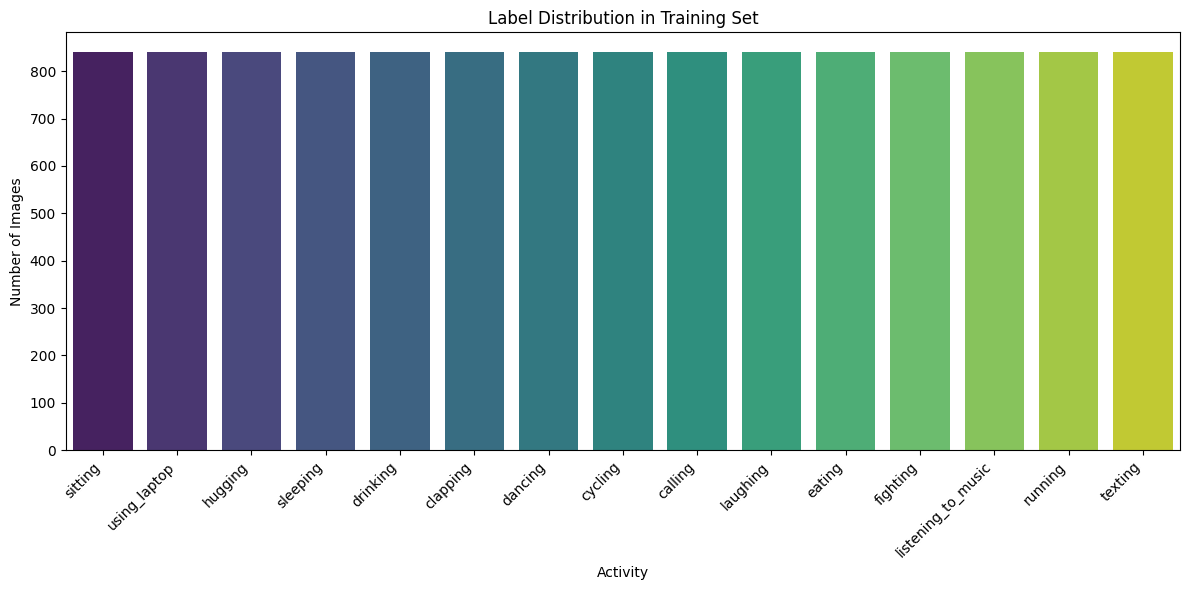

In [3]:
# Visualize label distribution to verify class balance
label_counts = train_data['label'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Label Distribution in Training Set')
plt.xlabel('Activity')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


## Section 3: Data Visualization

This section provides visual inspection of sample images from the dataset to understand the data quality and characteristics.


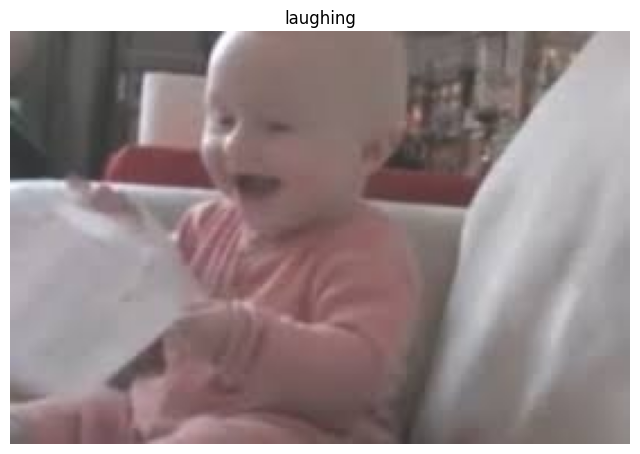

In [4]:
def displaying_random_images():
    """
    Display a random image from the training dataset with its label.
    This function helps visualize sample data to understand image quality and content.
    """
    # Generate random image number within dataset range
    num = random.randint(1, 12600)
    imgg = f"Image_{num}.jpg"
    img_path = os.path.join(train_folder, imgg)
    
    # Check if image file exists and display it
    if os.path.exists(img_path):
        testImage = img.imread(img_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(testImage)
        # Retrieve and display the corresponding label
        label = train_data.loc[train_data['filename'] == imgg, 'label'].values
        if len(label) > 0:
            plt.title(f"{label[0]}")
        plt.axis('off')  # Hide axes for cleaner visualization
        plt.show()
    else:
        print(f"File not found: {img_path}")

# Display a random sample image
displaying_random_images()


## Section 4: Data Preprocessing and Augmentation

This section sets up data generators with augmentation strategies to improve model generalization and prevent overfitting. The ImageDataGenerator automatically handles train-validation split.


In [5]:
# Training data generator with augmentation to increase dataset diversity
# Augmentation helps model generalize better by creating variations of training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet-specific preprocessing
    rotation_range=25,                        # Random rotation up to 25 degrees
    width_shift_range=0.15,                   # Random horizontal shift up to 15%
    height_shift_range=0.15,                  # Random vertical shift up to 15%
    shear_range=0.1,                          # Random shearing transformation
    zoom_range=0.2,                           # Random zoom between 80% and 120%
    horizontal_flip=True,                     # Random horizontal flipping
    brightness_range=[0.8, 1.2],             # Random brightness adjustment
    fill_mode='nearest',                      # Fill mode for transformed pixels
    validation_split=0.2                      # 20% of data reserved for validation
)

# Validation data generator without augmentation
# Validation data should remain unchanged to provide accurate performance metrics
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Only preprocessing, no augmentation
    validation_split=0.2                      # Same split ratio as training generator
)


In [6]:
# Create training data generator
# This generator loads images from dataframe, applies augmentation, and creates batches
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_data,                     # DataFrame with filenames and labels
    directory=train_folder,                   # Directory containing image files
    x_col="filename",                         # Column name for image filenames
    y_col="label",                            # Column name for class labels
    target_size=(160, 160),                   # Resize all images to 160x160 pixels
    batch_size=32,                            # Number of images per batch
    class_mode='categorical',                 # One-hot encoded labels
    subset='training',                        # Use training subset (80% of data)
    shuffle=True,                             # Shuffle data for better training
    seed=42                                   # Random seed for reproducibility
)

# Create validation data generator
# Validation generator uses same parameters but without augmentation
val_gen = val_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_folder,
    x_col="filename",
    y_col="label",
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='validation',                     # Use validation subset (20% of data)
    shuffle=False                            # No shuffling for consistent evaluation
)

# Extract and save class names for later use in inference
# Class names are automatically ordered by the generator
class_names = list(train_gen.class_indices.keys())
joblib.dump(class_names, "class_names.pkl")  # Save for use in test.py
print("Class names:", class_names)
print(f"Train samples: {train_gen.samples}")  # Number of training images
print(f"Val samples: {val_gen.samples}")      # Number of validation images


Found 10080 validated image filenames belonging to 15 classes.
Found 2520 validated image filenames belonging to 15 classes.
Class names: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Train samples: 10080
Val samples: 2520


In [7]:
# Verify batch shape and data format
# This helps ensure data generators are working correctly before training
x_batch, y_batch = next(train_gen)
print("Image batch shape:", x_batch.shape)  # Should be (batch_size, 160, 160, 3)
print("Label batch shape:", y_batch.shape)  # Should be (batch_size, num_classes)
print("First label (one-hot):", y_batch[0])  # One-hot encoded label vector
print("Class index:", np.argmax(y_batch[0]))  # Convert one-hot to class index
print("Activity name:", class_names[np.argmax(y_batch[0])])  # Human-readable class name


Image batch shape: (32, 160, 160, 3)
Label batch shape: (32, 15)
First label (one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class index: 3
Activity name: dancing


## Section 5: Build EfficientNet-B3 Model Architecture

This section constructs the deep learning model using EfficientNet-B3 as the base architecture. EfficientNet-B3 provides a good balance between accuracy and computational efficiency.


In [8]:
# Get number of classes from class names list
num_classes = len(class_names)

# Load EfficientNet-B3 base model pre-trained on ImageNet
# EfficientNet-B3 provides excellent feature extraction capabilities
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,           # Exclude top classification layer
    input_shape=(160, 160, 3),   # Input image dimensions (height, width, channels)
    pooling="avg",               # Global average pooling for feature maps
    weights="imagenet"           # Use pre-trained ImageNet weights
)

# Freeze all base model layers for initial training stage
# This allows the model to learn task-specific features while preserving ImageNet knowledge
for layer in base_model.layers:
    layer.trainable = False

# Build complete model architecture
# Sequential model combines base EfficientNet with custom classification head
efficientnet_model = Sequential([
    base_model,                                    # Pre-trained EfficientNet-B3 feature extractor
    Dense(512, activation="relu"),                # Fully connected layer with ReLU activation
    Dropout(0.5),                                  # Dropout layer to prevent overfitting (50% dropout rate)
    Dense(num_classes, activation="softmax")      # Output layer with softmax for multi-class classification
])

# Define loss function with label smoothing
# Label smoothing (0.1) helps prevent overconfident predictions and improves generalization
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Compile the model with optimizer, loss function, and evaluation metrics
efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Adam optimizer with initial learning rate of 0.0001
    loss=loss_fn,                         # Categorical crossentropy with label smoothing
    metrics=["accuracy"]                  # Track accuracy during training
)

# Display model architecture summary
# Shows layer types, output shapes, and number of parameters
efficientnet_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,578,174 (44.17 MB)

 Trainable params: 794,639 (3.03 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

## Section 6: Training Stage 1 - Transfer Learning with Frozen Base

In this stage, we train only the custom classification head while keeping the EfficientNet base frozen. This allows the model to adapt ImageNet features to our specific task.


In [ ]:
# Define training callbacks for better training control
callbacks = [
    # Reduce learning rate when validation accuracy plateaus
    # Helps fine-tune model when progress stalls
    ReduceLROnPlateau(
        monitor='val_accuracy',  # Metric to monitor
        factor=0.2,              # Multiply learning rate by 0.2 when triggered
        patience=3,              # Wait 3 epochs before reducing LR
        min_lr=1e-7,            # Minimum learning rate threshold
        verbose=1               # Print messages when LR is reduced
    ),
    # Stop training early if validation accuracy stops improving
    # Prevents overfitting and saves training time
    EarlyStopping(
        monitor='val_accuracy',      # Metric to monitor
        patience=8,                  # Wait 8 epochs without improvement before stopping
        restore_best_weights=True,   # Restore weights from best epoch
        verbose=1                    # Print messages when early stopping triggers
    ),
    # Save model checkpoint whenever validation accuracy improves
    # Ensures we always have the best model saved
    ModelCheckpoint(
        'best_model.keras',          # Filepath to save best model
        monitor='val_accuracy',      # Metric to monitor
        save_best_only=True,         # Only save when metric improves
        verbose=1                    # Print messages when model is saved
    )
]

# Train Stage 1: Train classification head with frozen base
EPOCHS = 25  # Maximum number of training epochs
history_stage1 = efficientnet_model.fit(
    train_gen,                      # Training data generator
    validation_data=val_gen,        # Validation data generator
    epochs=EPOCHS,                  # Number of epochs
    callbacks=callbacks,            # Training callbacks
    verbose=1                       # Verbosity level (1 = progress bar)
)



Epoch 1/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2410 - loss: 2.4607
Epoch 1: val_accuracy improved from None to 0.59841, saving model to best_model.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.3532 - loss: 2.1918 - val_accuracy: 0.5984 - val_loss: 1.6471 - learning_rate: 1.0000e-04
Epoch 2/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5131 - loss: 1.7949
Epoch 2: val_accuracy improved from 0.59841 to 0.62698, saving model to best_model.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.5180 - loss: 1.7709 - val_accuracy: 0.6270 - val_loss: 1.5084 - learning_rate: 1.0000e-04
Epoch 3/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5570 - loss: 1.6943
Epoch 3: val_accuracy improved from 0.62698 to 0.64048, saving model to best_model.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.5619 - loss: 1.6840 - val_accuracy: 0.6405 - val_loss: 1.4667 - learning_rate: 1.0000e-04
Epoch 4/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 

## Section 7: Training Stage 2 - Fine-tuning

In this stage, we unfreeze the last layers of EfficientNet and fine-tune with a lower learning rate. This allows the model to adapt pre-trained features more specifically to our task.


In [ ]:
# Unfreeze last 30 layers of EfficientNet for fine-tuning
# Fine-tuning deeper layers allows model to learn task-specific features
for layer in base_model.layers[-30:]:
    layer.trainable = True  # Enable training for these layers

# Recompile model with lower learning rate for fine-tuning
# Lower learning rate prevents overwriting valuable pre-trained features
efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Reduced learning rate (0.00001)
    loss=loss_fn,                        # Same loss function
    metrics=["accuracy"]                 # Same metrics
)

# Train Stage 2: Fine-tune unfrozen layers
history_stage2 = efficientnet_model.fit(
    train_gen,                      # Training data generator
    validation_data=val_gen,        # Validation data generator
    epochs=10,                      # Fewer epochs for fine-tuning
    callbacks=callbacks,            # Same callbacks as Stage 1
    verbose=1                       # Progress bar
)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1093 - loss: 2.7785
Epoch 1: val_accuracy improved from 0.12500 to 0.15000, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 86s 6s/step - accuracy: 0.1063 - loss: 2.7835 - val_accuracy: 0.1500 - val_loss: 2.7129 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 1.


## Section 8: Model Evaluation and Visualization

This section evaluates the trained model on the validation set, generates performance metrics, and creates visualizations including confusion matrix, per-class accuracy, and training history.


In [ ]:
# Evaluate model on validation set
# Generate predictions for all validation samples
val_steps = int(np.ceil(val_gen.samples / val_gen.batch_size))  # Calculate number of batches
val_predictions = efficientnet_model.predict(val_gen, steps=val_steps, verbose=1)

# Convert predictions to class indices
val_pred_classes = np.argmax(val_predictions, axis=1)  # Predicted class for each sample
val_true_classes = val_gen.classes                      # True class labels

# Extract confidence scores (maximum probability for predicted class)
confidence_scores = np.max(val_predictions, axis=1)

# Generate confusion matrix and classification report
cm = confusion_matrix(val_true_classes, val_pred_classes)
report = classification_report(val_true_classes, val_pred_classes, target_names=class_names)
print(report)  # Print detailed per-class metrics (precision, recall, F1-score)



2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 9s/step
                    precision    recall  f1-score   support

           calling       0.00      0.00      0.00         2
          clapping       0.00      0.00      0.00         2
           cycling       0.00      0.00      0.00         2
           dancing       0.00      0.00      0.00         4
          drinking       1.00      0.25      0.40         4
            eating       0.00      0.00      0.00         2
          fighting       0.00      0.00      0.00         2
           hugging       0.17      0.25      0.20         4
          laughing       0.00      0.00      0.00         3
listening_to_music       0.00      0.00      0.00         3
           running       0.22      0.67      0.33         3
           sitting       0.00      0.00      0.00         2
          sleeping       0.00      0.00      0.00         1
           texting       0.00      0.00      0.00         4
      using_laptop       0.12      1.00      0.21         2

 

d:\Activity-Recognition-from-Video\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Activity-Recognition-from-Video\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Activity-Recognition-from-Video\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

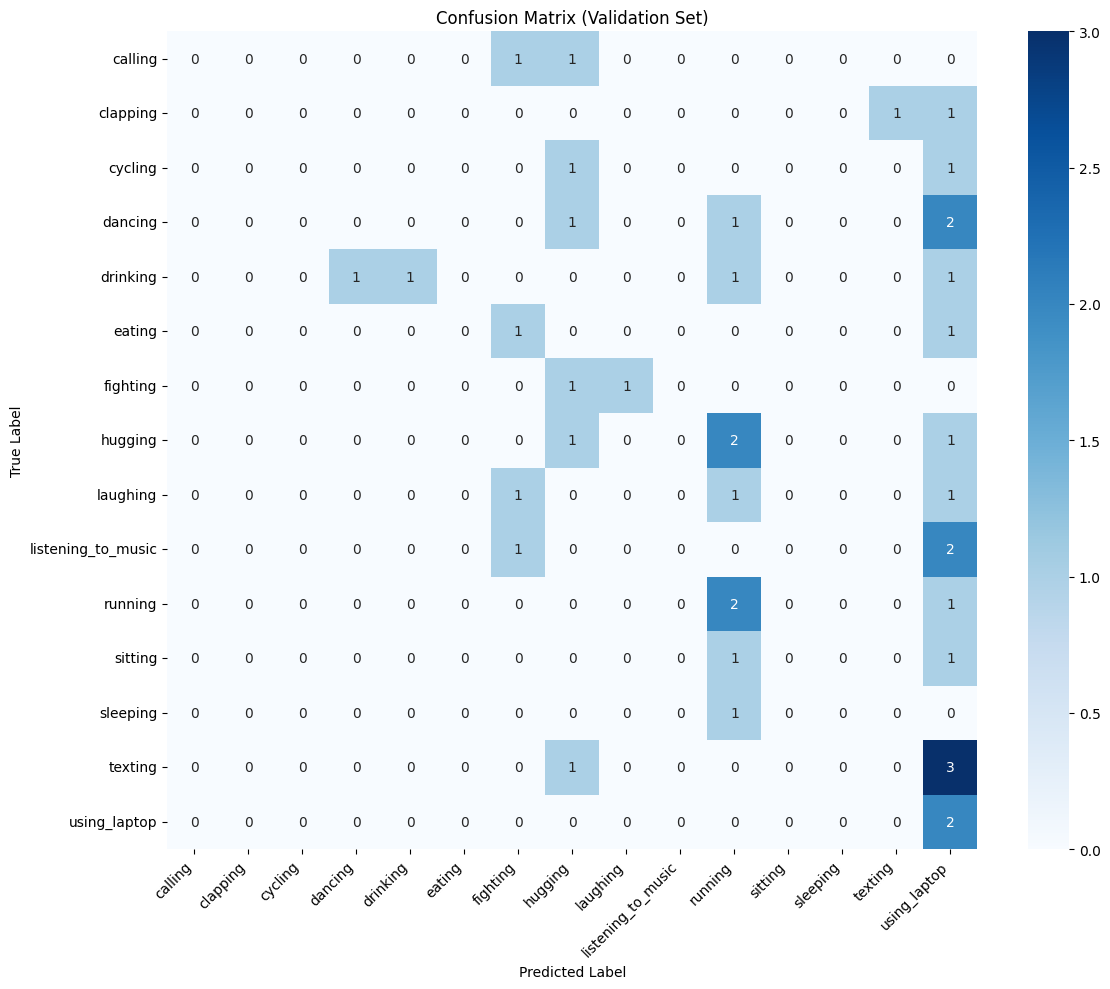

In [ ]:
# Visualize confusion matrix
# Confusion matrix shows how well the model predicts each class
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_validation.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()


C:\Users\S\AppData\Local\Temp\ipykernel_26644\3568113825.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=per_class_accuracy, palette='crest')


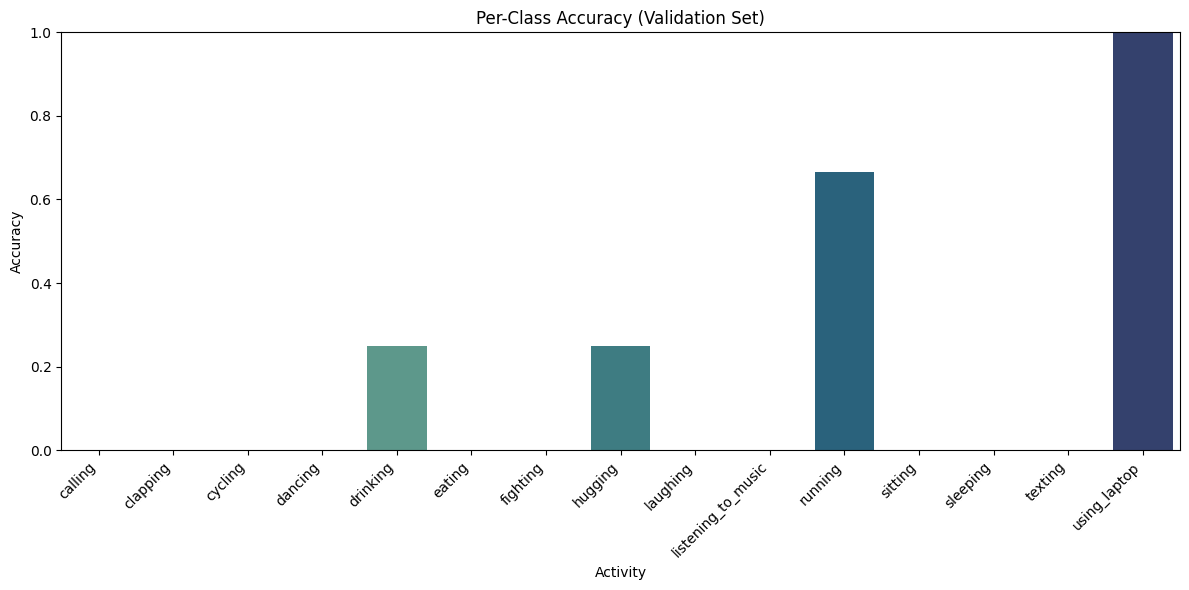

In [ ]:
# Calculate and visualize per-class accuracy
# Per-class accuracy = diagonal elements / row sums (true positives / total samples per class)
per_class_accuracy = cm.diagonal() / (cm.sum(axis=1) + 1e-10)  # Add small epsilon to avoid division by zero

plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=per_class_accuracy, palette='crest')
plt.ylim(0, 1)
plt.title('Per-Class Accuracy (Validation Set)', fontsize=14, fontweight='bold')
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('per_class_accuracy_validation.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()


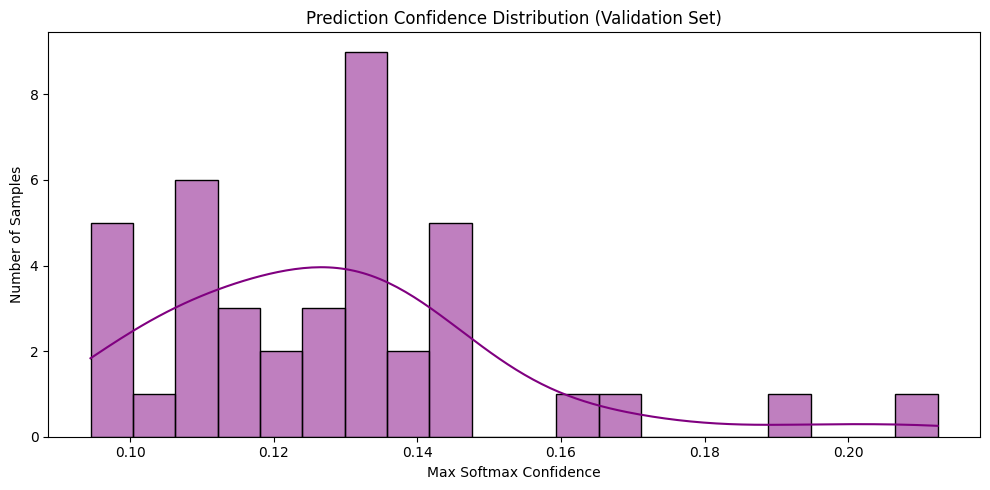

In [ ]:
# Visualize distribution of prediction confidence scores
# Higher confidence indicates more certain predictions
plt.figure(figsize=(10, 5))
sns.histplot(confidence_scores, bins=20, kde=True, color='purple')
plt.title('Prediction Confidence Distribution (Validation Set)', fontsize=14, fontweight='bold')
plt.xlabel('Max Softmax Confidence', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.tight_layout()
plt.savefig('confidence_distribution_validation.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()



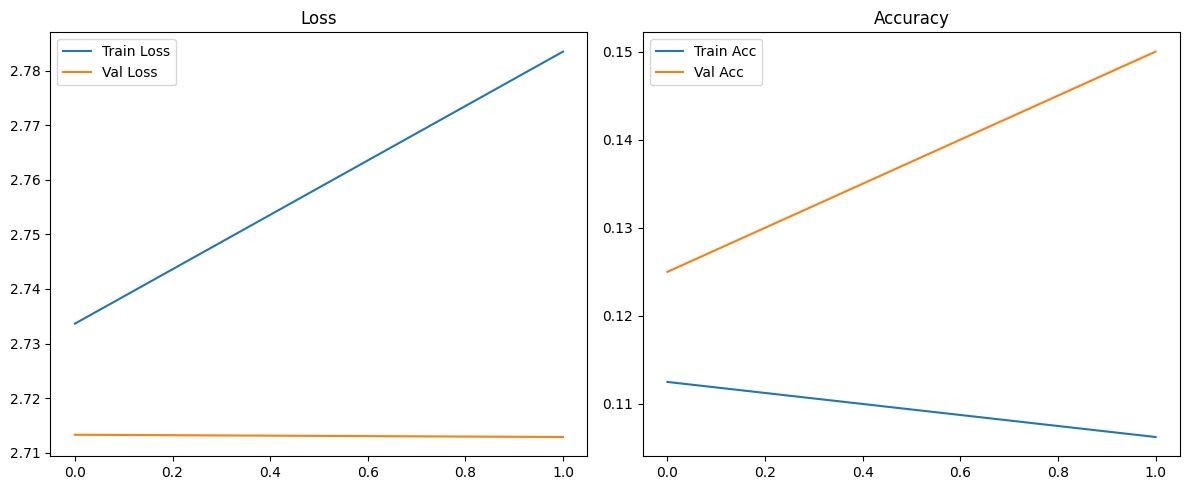

Best Val Accuracy: 15.00%


In [ ]:
# Combine training histories from both stages for complete visualization
history_combined = {
    'loss': history_stage1.history['loss'] + history_stage2.history['loss'],
    'val_loss': history_stage1.history['val_loss'] + history_stage2.history['val_loss'],
    'accuracy': history_stage1.history['accuracy'] + history_stage2.history['accuracy'],
    'val_accuracy': history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']
}

# Plot training history: loss and accuracy curves
plt.figure(figsize=(14, 5))

# Plot 1: Loss curves
plt.subplot(1, 2, 1)
plt.plot(history_combined['loss'], label='Train Loss', linewidth=2)
plt.plot(history_combined['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history_combined['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_combined['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()

# Print best validation accuracy achieved during training
print(f"Best Val Accuracy: {max(history_combined['val_accuracy'])*100:.2f}%")


## Section 9: Save Final Model

This section saves the best model (based on validation accuracy) for deployment and inference.


In [ ]:
# Load the best model checkpoint (saved by ModelCheckpoint callback)
# This ensures we use the model with the best validation accuracy, not the final epoch
if os.path.exists('best_model.keras'):
    print("Loading best model (best validation accuracy)...")
    best_model = tf.keras.models.load_model('best_model.keras')
    # Save as final model for use in inference script (test.py)
    best_model.save('activity_recognition_model.keras')
    print("Best model saved as 'activity_recognition_model.keras'")
else:
    # Fallback: save current model if checkpoint doesn't exist
    efficientnet_model.save('activity_recognition_model.keras')
    print("Model saved as 'activity_recognition_model.keras'")

# Class names were already saved earlier in Section 4
print("Class names saved as 'class_names.pkl'")
print("\nTraining complete! Model is ready for inference.")


Loading best model (best validation accuracy)...
Best model saved as 'activity_recognition_model.keras'
Class names saved as 'class_names.pkl'


## Section 10: Comprehensive Evaluation and Results Generation

This section performs comprehensive evaluation on the validation set and generates detailed metrics tables saved to result.txt for use in reports. All evaluation metrics, confusion matrices, and per-class statistics are included.


In [ ]:
# Comprehensive evaluation and results generation
# This cell generates all evaluation metrics and saves them to result.txt

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    cohen_kappa_score,
    matthews_corrcoef
)
from datetime import datetime

# Calculate comprehensive metrics
accuracy = accuracy_score(val_true_classes, val_pred_classes)
precision, recall, f1, support = precision_recall_fscore_support(
    val_true_classes, val_pred_classes, average=None, zero_division=0
)

# Macro averages (unweighted mean across all classes)
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

# Weighted averages (weighted by support/sample count)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
    val_true_classes, val_pred_classes, average='weighted', zero_division=0
)

# Additional metrics
kappa = cohen_kappa_score(val_true_classes, val_pred_classes)
mcc = matthews_corrcoef(val_true_classes, val_pred_classes)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)

# Confidence statistics by class
confidence_by_class_mean = []
confidence_by_class_std = []
confidence_by_class_min = []
confidence_by_class_max = []

for i in range(len(class_names)):
    mask = val_pred_classes == i
    if np.sum(mask) > 0:
        class_confidences = confidence_scores[mask]
        confidence_by_class_mean.append(np.mean(class_confidences))
        confidence_by_class_std.append(np.std(class_confidences))
        confidence_by_class_min.append(np.min(class_confidences))
        confidence_by_class_max.append(np.max(class_confidences))
    else:
        confidence_by_class_mean.append(0.0)
        confidence_by_class_std.append(0.0)
        confidence_by_class_min.append(0.0)
        confidence_by_class_max.append(0.0)

# Save comprehensive results to result.txt
with open('result.txt', 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("HUMAN ACTIVITY RECOGNITION MODEL - COMPREHENSIVE EVALUATION REPORT\n")
    f.write("="*80 + "\n")
    f.write(f"Evaluation Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model Architecture: EfficientNet-B3\n")
    f.write(f"Dataset: Validation Set (20% split from training data)\n")
    f.write(f"Total Classes: {len(class_names)}\n")
    f.write(f"Total Samples: {int(np.sum(support))}\n")
    f.write("="*80 + "\n\n")
    
    # Overall Model Performance Metrics
    f.write("OVERALL MODEL PERFORMANCE METRICS\n")
    f.write("-"*80 + "\n")
    f.write(f"{'Metric':<35} {'Value':<20} {'Percentage':<20}\n")
    f.write("-"*80 + "\n")
    f.write(f"{'Accuracy':<35} {accuracy:<20.6f} {accuracy*100:<20.2f}%\n")
    f.write(f"{'Macro Average Precision':<35} {macro_precision:<20.6f} {macro_precision*100:<20.2f}%\n")
    f.write(f"{'Macro Average Recall':<35} {macro_recall:<20.6f} {macro_recall*100:<20.2f}%\n")
    f.write(f"{'Macro Average F1-Score':<35} {macro_f1:<20.6f} {macro_f1*100:<20.2f}%\n")
    f.write(f"{'Weighted Average Precision':<35} {weighted_precision:<20.6f} {weighted_precision*100:<20.2f}%\n")
    f.write(f"{'Weighted Average Recall':<35} {weighted_recall:<20.6f} {weighted_recall*100:<20.2f}%\n")
    f.write(f"{'Weighted Average F1-Score':<35} {weighted_f1:<20.6f} {weighted_f1*100:<20.2f}%\n")
    f.write(f"{'Cohen Kappa Score':<35} {kappa:<20.6f} {'N/A':<20}\n")
    f.write(f"{'Matthews Correlation Coefficient':<35} {mcc:<20.6f} {'N/A':<20}\n")
    f.write(f"{'Mean Confidence Score':<35} {np.mean(confidence_scores):<20.6f} {np.mean(confidence_scores)*100:<20.2f}%\n")
    f.write(f"{'Median Confidence Score':<35} {np.median(confidence_scores):<20.6f} {np.median(confidence_scores)*100:<20.2f}%\n")
    f.write(f"{'Standard Deviation Confidence':<35} {np.std(confidence_scores):<20.6f} {'N/A':<20}\n")
    f.write("\n")
    
    # Per-Class Performance Metrics Table
    f.write("PER-CLASS PERFORMANCE METRICS\n")
    f.write("-"*80 + "\n")
    f.write(f"{'Class':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Accuracy':<12} {'Support':<10}\n")
    f.write("-"*80 + "\n")
    
    for i, class_name in enumerate(class_names):
        f.write(f"{class_name:<25} {precision[i]:<12.4f} {recall[i]:<12.4f} "
               f"{f1[i]:<12.4f} {per_class_accuracy[i]:<12.4f} {int(support[i]):<10}\n")
    
    f.write("\n")
    
    # Confusion Matrix
    f.write("CONFUSION MATRIX\n")
    f.write("-"*80 + "\n")
    f.write(f"{'True\\Pred':<20}")
    for class_name in class_names:
        f.write(f"{class_name[:10]:<12}")
    f.write("\n")
    f.write("-"*80 + "\n")
    
    for i, class_name in enumerate(class_names):
        f.write(f"{class_name[:18]:<20}")
        for j in range(len(class_names)):
            f.write(f"{cm[i, j]:<12}")
        f.write("\n")
    
    f.write("\n")
    
    # Normalized Confusion Matrix
    f.write("NORMALIZED CONFUSION MATRIX (Row Normalized)\n")
    f.write("-"*80 + "\n")
    f.write(f"{'True\\Pred':<20}")
    for class_name in class_names:
        f.write(f"{class_name[:10]:<12}")
    f.write("\n")
    f.write("-"*80 + "\n")
    
    for i, class_name in enumerate(class_names):
        f.write(f"{class_name[:18]:<20}")
        for j in range(len(class_names)):
            f.write(f"{cm_normalized[i, j]:<12.4f}")
        f.write("\n")
    
    f.write("\n")
    
    # Confidence Statistics by Class
    f.write("CONFIDENCE STATISTICS BY CLASS\n")
    f.write("-"*80 + "\n")
    f.write(f"{'Class':<25} {'Mean Confidence':<18} {'Std Confidence':<18} {'Min Confidence':<18} {'Max Confidence':<18}\n")
    f.write("-"*80 + "\n")
    
    for i, class_name in enumerate(class_names):
        f.write(f"{class_name:<25} {confidence_by_class_mean[i]:<18.4f} "
               f"{confidence_by_class_std[i]:<18.4f} {confidence_by_class_min[i]:<18.4f} "
               f"{confidence_by_class_max[i]:<18.4f}\n")
    
    f.write("\n")
    
    # Summary Statistics
    f.write("SUMMARY STATISTICS\n")
    f.write("-"*80 + "\n")
    f.write(f"Total Validation Samples: {int(np.sum(support))}\n")
    f.write(f"Correct Predictions: {int(np.sum(cm.diagonal()))}\n")
    f.write(f"Incorrect Predictions: {int(np.sum(support) - np.sum(cm.diagonal()))}\n")
    f.write(f"Classes with Perfect Accuracy: {int(np.sum(per_class_accuracy == 1.0))}\n")
    f.write(f"Classes with Zero Accuracy: {int(np.sum(per_class_accuracy == 0.0))}\n")
    f.write(f"Best Performing Class: {class_names[np.argmax(per_class_accuracy)]} "
           f"(Accuracy: {np.max(per_class_accuracy):.4f})\n")
    f.write(f"Worst Performing Class: {class_names[np.argmin(per_class_accuracy)]} "
           f"(Accuracy: {np.min(per_class_accuracy):.4f})\n")
    
    f.write("\n")
    f.write("="*80 + "\n")
    f.write("END OF EVALUATION REPORT\n")
    f.write("="*80 + "\n")

print("Comprehensive evaluation complete!")
print(f"Results saved to: result.txt")
print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Macro F1-Score: {macro_f1:.4f} ({macro_f1*100:.2f}%)")
print(f"Weighted F1-Score: {weighted_f1:.4f} ({weighted_f1*100:.2f}%)")
